https://www.kaggle.com/code/muhammadfaizan65/parking-lot-detection-counter

In [11]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML
import ipywidgets as widgets
from ultralytics import YOLO

In [8]:
EMPTY = True
NOT_EMPTY = False

# Load the pre-trained model
model_path = "C:/Jeonghwan/data/archive/parking/model/model.p"
MODEL = pickle.load(open(model_path, "rb"))


# Helper functions from util.py
def empty_or_not(spot_bgr):
    if spot_bgr is None or spot_bgr.size == 0:
        return NOT_EMPTY  # Treat invalid spots as occupied
    try:
        flat_data = []
        img_resized = resize(spot_bgr, (15, 15, 3))
        flat_data.append(img_resized.flatten())
        flat_data = np.array(flat_data)
        y_output = MODEL.predict(flat_data)
        return EMPTY if y_output == 0 else NOT_EMPTY
    except Exception as e:
        print(f"Error processing spot: {e}")
        return NOT_EMPTY  # Treat errors as occupied
    

def get_parking_spots_bboxes(connected_components):
    (totalLabels, label_ids, values, centroid) = connected_components
    slots = []
    coef = 1
    for i in range(1, totalLabels):
        x1 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y1 = int(values[i, cv2.CC_STAT_TOP] * coef)
        w = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        h = int(values[i, cv2.CC_STAT_HEIGHT] * coef)
        slots.append([x1, y1, w, h])
    return slots

# Load mask image
mask_img_path = "C:/Jeonghwan/data/archive/parking/PL_Mask.png"
# mask_img_path = "C:/Jeonghwan/data/archive/parking/mask_1920_1080.png"
mask_img = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)

# Find connected components in the mask image
connected_components = cv2.connectedComponentsWithStats(mask_img, connectivity=8, ltype=cv2.CV_32S)
parking_bboxes = get_parking_spots_bboxes(connected_components)

# EDA and visualization
def visualize_parking_spots(image, bboxes, title="Parking Spots"):
    for bbox in bboxes:
        x, y, w, h = bbox
        if w > 0 and h > 0:  # Ensure valid bounding box dimensions
            spot = image[y:y+h, x:x+w]
            if spot.shape[0] > 0 and spot.shape[1] > 0:  # Ensure valid spot dimensions
                status = empty_or_not(spot)
                color = (0, 255, 0) if status == EMPTY else (0, 0, 255)
                cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Extract a frame from the video
def extract_frame_from_video(video_path, frame_number=0):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return frame
    else:
        raise ValueError("Unable to extract frame from video.")

# image visualization
video_path = "C:/data/archive/parking/parking_1920_1080_loop.mp4"
example_frame = extract_frame_from_video(video_path)
visualize_parking_spots(example_frame, parking_bboxes)


# Process video and detect parking spot status
def process_video(video_path, bboxes, model, output_path):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        for bbox in bboxes:
            x, y, w, h = bbox
            if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                spot = frame[y:y+h, x:x+w]
                if spot.shape[0] > 0 and spot.shape[1] > 0:  # Ensure valid spot dimensions
                    status = empty_or_not(spot)
                    color = (0, 255, 0) if status == EMPTY else (0, 0, 255)
                    cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        
        out.write(frame)
    
    cap.release()
    out.release()

# Process and save video
input_video_path = "C:/Users/user/OneDrive/바탕 화면/for_test.png"
output_video_path = "C:/Users/user/OneDrive/바탕 화면/masked_test.png"
process_video(input_video_path, parking_bboxes, MODEL, output_video_path)


# Verify the video was saved correctly
if os.path.exists(output_video_path):
    print(f"Video saved successfully at {output_video_path}")
    # Check the size of the video
    video_size = os.path.getsize(output_video_path)
    if video_size > 0:
        print(f"Video size: {video_size} bytes")
        # Display the processed video using IPython widgets
        video_widget = widgets.Video.from_file(output_video_path)
        video_widget.width = 800
        video_widget.height = 600
        display(video_widget)
    else:
        print("The video file is empty.")
else:
    raise FileNotFoundError(f"Processed video not found at {output_video_path}")

# Save processed images with bounding boxes
def save_processed_images(image_paths, bboxes, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for image_path in image_paths:
        image = cv2.imread(image_path)
        if image is None:
            continue
        for bbox in bboxes:
            x, y, w, h = bbox
            if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                spot = image[y:y+h, x:x+w]
                if spot.shape[0] > 0 and spot.shape[1] > 0:  # Ensure valid spot dimensions
                    status = empty_or_not(spot)
                    color = (0, 255, 0) if status == EMPTY else (0, 0, 255)
                    cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        cv2.imwrite(output_path, image)

# Process and save images
image_dir = "C:/data/archive/parking/clf-data"
empty_dir = os.path.join(image_dir, "empty")
not_empty_dir = os.path.join(image_dir, "not_empty")
output_image_dir = "C:/data/archive/parking/processed_images"

empty_images = [os.path.join(empty_dir, img) for img in os.listdir(empty_dir)]
not_empty_images = [os.path.join(not_empty_dir, img) for img in os.listdir(not_empty_dir)]
all_images = empty_images + not_empty_images

save_processed_images(all_images, parking_bboxes, output_image_dir)


# Interactive visualization using Plotly
def interactive_visualization(image, bboxes):
    fig = px.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for bbox in bboxes:
        x, y, w, h = bbox
        if w > 0 and h > 0:  # Ensure valid bounding box dimensions
            spot = image[y:y+h, x:x+w]
            if spot.shape[0] > 0 and spot.shape[1] > 0:  # Ensure valid spot dimensions
                status = empty_or_not(spot)
                color = "green" if status == EMPTY else "red"
                fig.add_shape(type="rect",
                              x0=x, y0=y, x1=x+w, y1=y+h,
                              line=dict(color=color, width=2))
    fig.update_layout(title="Interactive Parking Spot Detection", margin=dict(l=0, r=0, t=30, b=0))
    fig.show()

# Example interactive visualization
interactive_visualization(example_frame, parking_bboxes)

ValueError: Unable to extract frame from video.


Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error processing spot: axes don't match array

Error proces

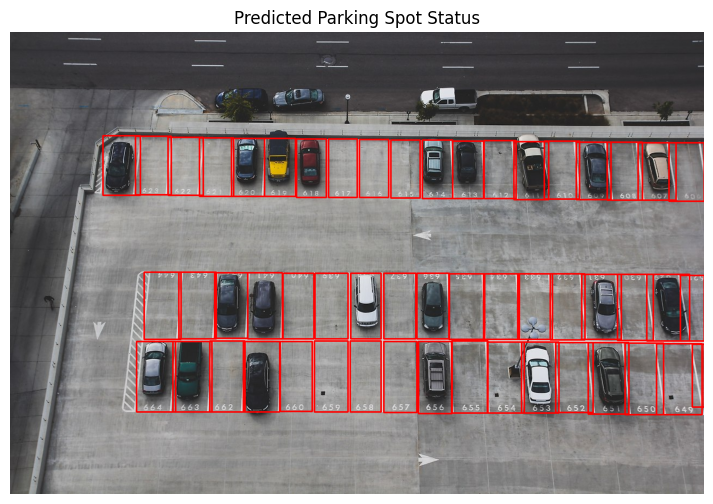

✅ 예측된 이미지가 저장되었습니다: C:/Jeonghwan/data/archive/parking/mask_test_result.png


In [13]:
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 주차 상태 설정
EMPTY = True
NOT_EMPTY = False

# 사전 학습된 모델 로드
model_path = "C:/Jeonghwan/data/archive/parking/model/model.p"
# MODEL = pickle.load(open(model_path, "rb"))
MODEL_SAVE_PATH = os.path.join("C:/data/PKLot/best_0227.pt")
# 학습된 모델 불러오기
MODEL = YOLO(MODEL_SAVE_PATH)

# 마스크 이미지 로드
mask_img_path = "C:/Jeonghwan/data/archive/parking/PL_Mask.png"
mask_img = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)

# 주차 공간 검출 함수
def get_parking_spots_bboxes(connected_components):
    (totalLabels, label_ids, values, centroid) = connected_components
    slots = []
    coef = 1
    for i in range(1, totalLabels):
        x1 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y1 = int(values[i, cv2.CC_STAT_TOP] * coef)
        w = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        h = int(values[i, cv2.CC_STAT_HEIGHT] * coef)
        slots.append([x1, y1, w, h])
    return slots

# 마스크를 이용한 주차 공간 탐지
connected_components = cv2.connectedComponentsWithStats(mask_img, connectivity=8, ltype=cv2.CV_32S)
parking_bboxes = get_parking_spots_bboxes(connected_components)

# 개별 이미지에서 주차 공간 예측 함수
def empty_or_not(spot_bgr):
    if spot_bgr is None or spot_bgr.size == 0:
        return NOT_EMPTY  # 오류 방지를 위해 기본적으로 occupied 처리
    try:
        flat_data = []
        img_resized = cv2.resize(spot_bgr, (15, 15))  # YOLO가 아닌 기존 모델 입력 크기로 조정
        flat_data.append(img_resized.flatten())
        flat_data = np.array(flat_data)
        y_output = MODEL.predict(flat_data)
        return EMPTY if y_output == 0 else NOT_EMPTY
    except Exception as e:
        print(f"Error processing spot: {e}")
        return NOT_EMPTY  # 오류 발생 시 기본 occupied 처리

# 이미지에서 주차 공간 감지 및 시각화
def process_image(image_path, output_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"이미지를 불러올 수 없습니다: {image_path}")

    for bbox in parking_bboxes:
        x, y, w, h = bbox
        if w > 0 and h > 0:  # 유효한 박스만 처리
            spot = image[y:y+h, x:x+w]
            if spot.shape[0] > 0 and spot.shape[1] > 0:
                status = empty_or_not(spot)
                color = (0, 255, 0) if status == EMPTY else (0, 0, 255)  # 초록(빈공간) / 빨강(차 있음)
                cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)

    # 예측된 이미지 저장
    cv2.imwrite(output_path, image)

    # 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Predicted Parking Spot Status")
    plt.axis("off")
    plt.show()

# 이미지 예측 실행
input_image_path = "C:/Jeonghwan/data/archive/parking/for_test_2.png"
output_image_path = "C:/Jeonghwan/data/archive/parking/mask_test_result.png"
process_image(input_image_path, output_image_path)

print(f"✅ 예측된 이미지가 저장되었습니다: {output_image_path}")